In [6]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


2.13.0


In [8]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.2)

zip_file_path = '/content/drive/MyDrive/test_data/firef.zip'
extraction_folder = '/content/extract_d'
import zipfile

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_folder)

    data_directory = extraction_folder


DATA_PATH = "/content/extract_d/ff/Training"

train_data = datagen.flow_from_directory(
                DATA_PATH,
                target_size=(224, 224),
                class_mode="binary",
                batch_size=32,
                shuffle=True,
                subset='training',
                seed=42)
test_data = datagen.flow_from_directory(
                DATA_PATH,
                target_size=(224, 224),
                class_mode="binary",
                shuffle=False,
                batch_size=32,
                subset='validation',
                seed=42)

Found 1216 images belonging to 2 classes.
Found 304 images belonging to 2 classes.


In [9]:
class_names = ['Fire', 'No Fire']

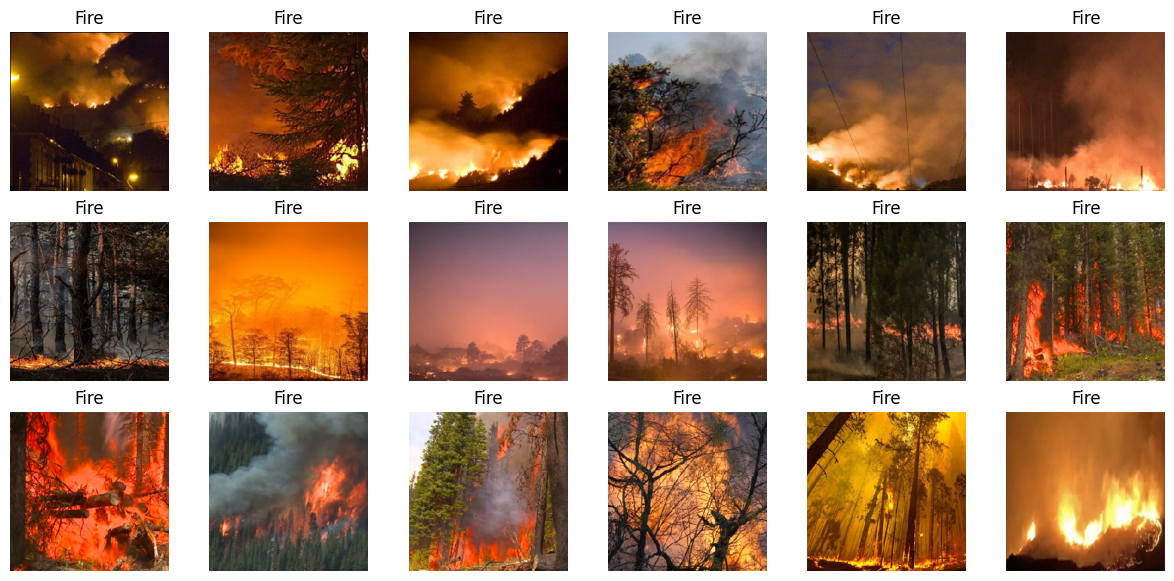

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7))
images, labels = next(test_data)
i=0
for image, label in zip(images, labels):
  ax = plt.subplot(3, 6, i + 1)
  plt.imshow(image.astype("uint8"))
  plt.title(class_names[int(label)])
  plt.axis("off")
  i+=1
  if i==18: break

In [11]:
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Activation

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = Input(shape=(224, 224, 3), name="input_layer")
x = base_model(inputs)

x = GlobalAveragePooling2D(name="GlobalAveragePooling2D")(x)

x = Dense(1, name='output_layer')(x)
outputs = Activation('sigmoid', name='sigmoid_activation')(x)

model = tf.keras.Model(inputs, outputs)

model.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])

model.summary()

16705208/16705208 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 GlobalAveragePooling2D (Gl  (None, 1280)              0         
 obalAveragePooling2D)                                           
                                                                 
 output_layer (Dense)        (None, 1)                 1281      
                                                                 
 sigmoid_activation (Activa  (None, 1)                 0         
 tion)                                                        

In [12]:
history = model.fit(train_data,
                    epochs=5,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=len(test_data))

Epoch 1/5
38/38 [==============================] - 120s 3s/step - loss: 0.3330 - accuracy: 0.9482 - val_loss: 0.1799 - val_accuracy: 0.9803
Epoch 2/5
38/38 [==============================] - 128s 3s/step - loss: 0.1202 - accuracy: 0.9885 - val_loss: 0.1113 - val_accuracy: 0.9836
Epoch 3/5
38/38 [==============================] - 128s 3s/step - loss: 0.0754 - accuracy: 0.9893 - val_loss: 0.0897 - val_accuracy: 0.9836
Epoch 4/5
38/38 [==============================] - 128s 3s/step - loss: 0.0597 - accuracy: 0.9901 - val_loss: 0.0768 - val_accuracy: 0.9836
Epoch 5/5
38/38 [==============================] - 128s 3s/step - loss: 0.0472 - accuracy: 0.9942 - val_loss: 0.0702 - val_accuracy: 0.9836


In [19]:
model.save("exported_model.h5")

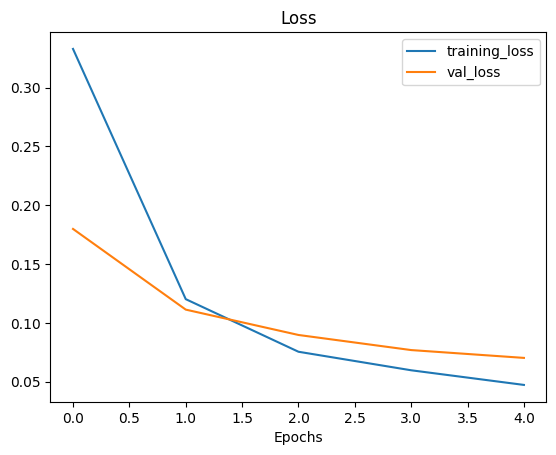

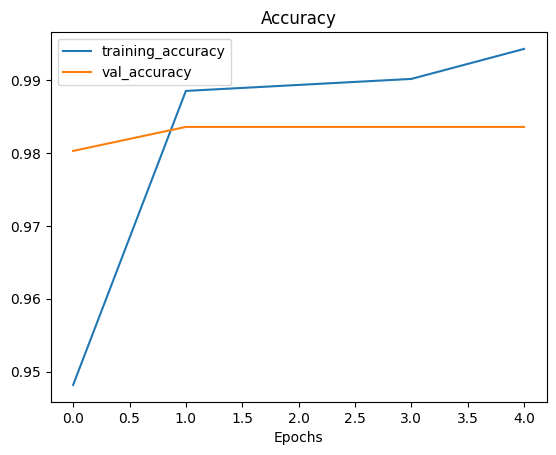

In [15]:

loss = history.history['loss']
val_loss = history.history['val_loss']

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(len(history.history['loss']))

# Plot loss
plt.plot(epochs, loss, label='training_loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

# Plot accuracy
plt.figure()
plt.plot(epochs, accuracy, label='training_accuracy')
plt.plot(epochs, val_accuracy, label='val_accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend();

In [23]:
y_pred = model.predict(test_data)
y_pred = np.squeeze(np.round(y_pred), axis=1)

y_true = test_data.classes

len(y_pred), len(y_true)

10/10 [==============================] - 25s 2s/step


(304, 304)

In [24]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       152
           1       0.99      0.98      0.98       152

    accuracy                           0.98       304
   macro avg       0.98      0.98      0.98       304
weighted avg       0.98      0.98      0.98       304



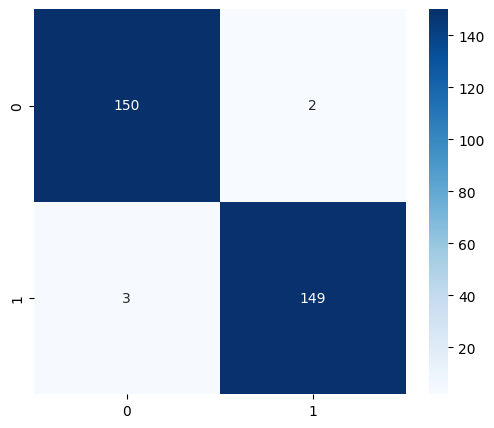

In [25]:
cm = tf.math.confusion_matrix(y_true, y_pred)

import seaborn as sn
plt.figure(figsize = (6, 5));
sn.heatmap(cm, annot=True,
           fmt='',
           cmap='Blues');

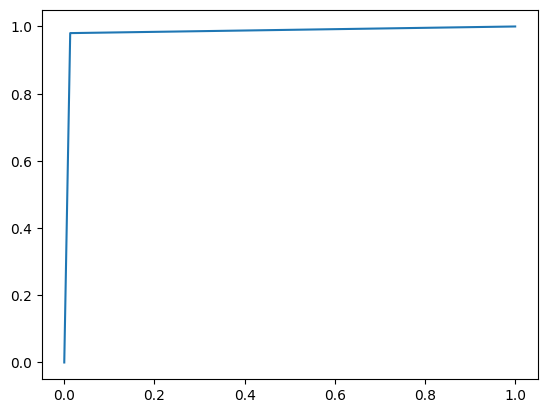

In [26]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
import matplotlib.pyplot as plt
plt.plot(fpr,tpr)
plt.show();

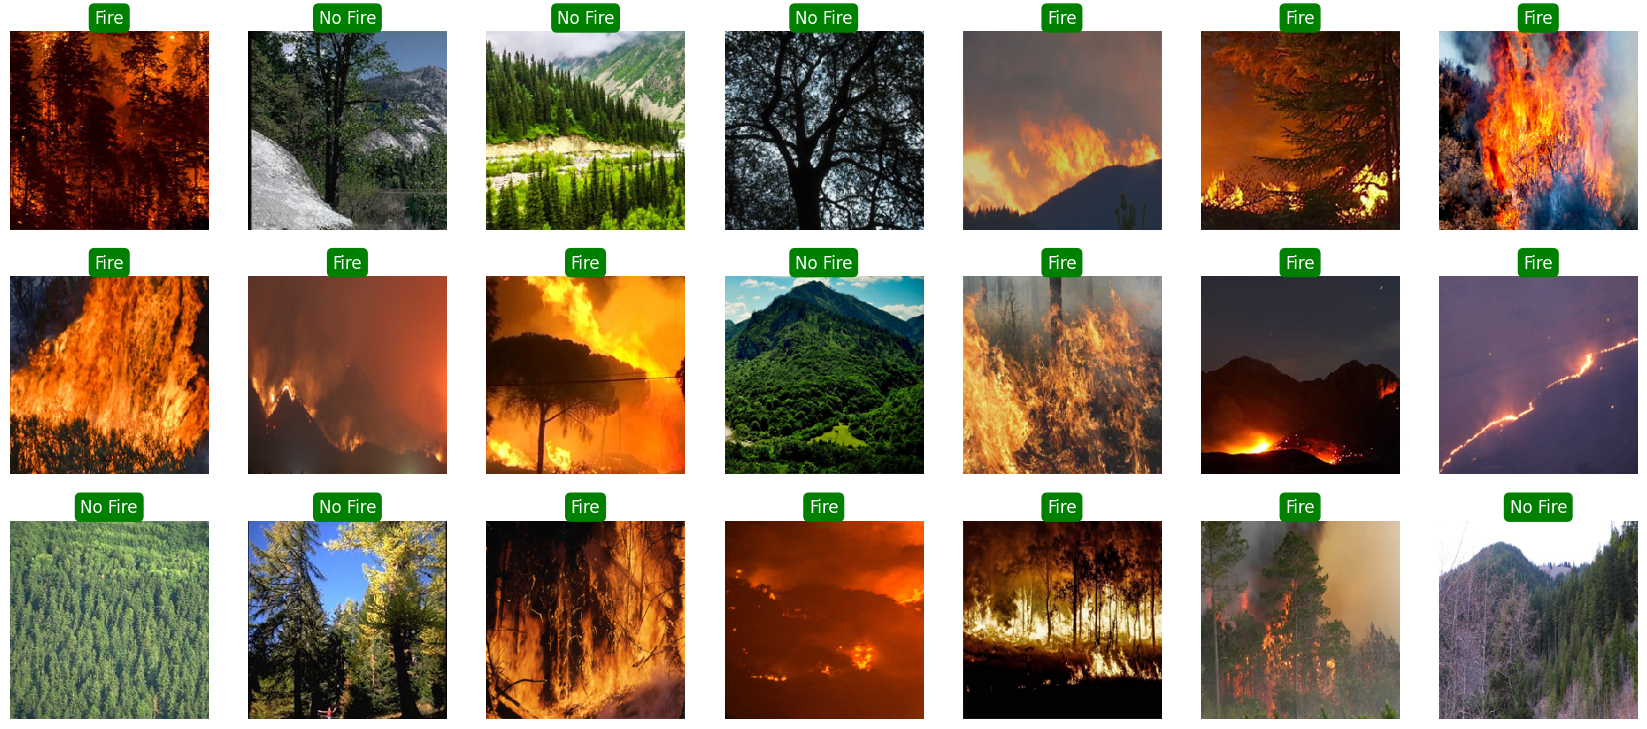

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(21, 9))

shuffle_test_data = test_data
shuffle_test_data.shuffle = True
images, labels = next(shuffle_test_data)

i=0

for image, label in zip(images, labels):
  ax = plt.subplot(3, 7, i + 1)
  plt.imshow(image.astype("uint8"))

  x=label
  pred_prob = model.predict(tf.expand_dims(image, axis=0), verbose=0)
  pred = class_names[int(np.round(pred_prob)[0])]

  if pred==class_names[int(x)]:
    plt.title(f"{pred}", color='white',
              bbox=dict(boxstyle="round",
                        color='green'))
  else:
    plt.title(f"{pred}", color='white',
              bbox=dict(boxstyle="round",
                        color='red'))
  plt.axis("off")
  i+=1
  if i==21: break